## Eccentric Residual Search Ideal

This notebook tests on a simulated dataset containing an eccentric gw signal. Based on work done by Sarah Vigeland, Ph.D. from `cw_search_sample.ipynb`

Updated: 03/02/2021

In [1]:
from __future__ import division
import numpy as np
import glob
import os
import pickle
import json
import matplotlib.pyplot as plt
import corner
import sys

from enterprise.signals import parameter
from enterprise.pulsar import Pulsar
from enterprise.signals import selections
from enterprise.signals import signal_base
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals
import enterprise.constants as const
from enterprise.signals import utils
from enterprise_extensions.deterministic import CWSignal
from enterprise.signals.signal_base import SignalCollection
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc
from enterprise_extensions.sampler import JumpProposal as JP
import arviz as az
import libstempo as T
import libstempo.plot as LP, libstempo.toasim as LT
import ecc_res
import scipy.constants as sc
os.environ["OMP_NUM_THREADS"] = "4"

%load_ext autoreload
%autoreload 2

Cannot import PINT? Meh...


In [2]:
def get_noise_from_pal2(noisefile):
    psrname = noisefile.split('/')[-1].split('_noise.txt')[0]
    fin = open(noisefile, 'r')
    lines = fin.readlines()
    params = {}
    for line in lines:
        ln = line.split()
        if 'efac' in line:
            par = 'efac'
            flag = ln[0].split('efac-')[-1]
        else:
            break
        if flag:
            name = [psrname, flag, par]
        else:
            name = [psrname, par]
        pname = '_'.join(name)
        params.update({pname: float(ln[1])})
    return params

In [3]:
#Simulated dataset directory path
datadir = '/home/bcheeseboro/nanograv_proj/enterprise_proj/ecc_signal_create/ecc_sim_data/fixed_coords/correct_dist/efac_added/logmc_9.5/source4/'
noisepath = '/home/bcheeseboro/nanograv_proj/enterprise_proj/ecc_signal_create/small_pta_noise'

In [4]:
#load par, tim, and noise files for each of the pulsars
parfiles = sorted(glob.glob(datadir+'/*.par'))
timfiles = sorted(glob.glob(datadir+'/*.tim'))
noisefiles = sorted(glob.glob(noisepath+'/*.txt'))

In [5]:
#Create the pulsar list
psr_list = [x.split('/')[-1].split('_')[0] for x in parfiles]
filename = datadir + 'ideal_pulsars_ecc_search.pkl'

In [6]:
#if there's a pickle file then use that
if os.path.exists(filename):
    with open(filename, "rb") as f:
        psrs = pickle.load(f)
#else load the par and tim files in and make a pickle file for the future
else:
    psrs = []
    for p, t in zip(parfiles, timfiles):
        print('Loading pulsar from parfile {0}'.format(p))
        psrs.append(Pulsar(p, t))
    pickle.dump(psrs, open(datadir+'ideal_pulsars_ecc_search.pkl', 'wb'))

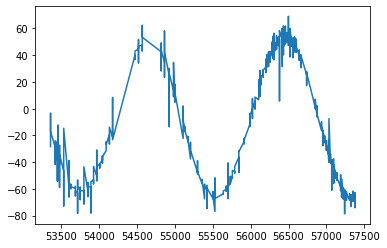

In [7]:
plt.plot(psrs[0].toas/86400, psrs[0].residuals/1e-6)

In [8]:
# white noise parameter
efac = parameter.Constant()
selection = selections.Selection(selections.by_backend)
# white noise signal
ef = white_signals.MeasurementNoise(efac=efac, selection=selection)

In [9]:
#Eccentric gw parameters
#gw parameters
gwphi = parameter.Constant(5.02)('gwphi') #RA of source
gwtheta = parameter.Constant(2.51)('gwtheta') #DEC of source
log10_dist = parameter.Constant(6.0)('log10_dist') #distance to source

#orbital parameters
l0 = parameter.Constant(0)('l0') #mean anomaly
gamma0 = parameter.Constant(0)('gamma0') #initial angle of periastron
inc = parameter.Constant(np.pi/3)('inc') #inclination of the binary's orbital plane
psi = parameter.Constant(0)('psi') #polarization of the GW

#Search parameters
#when searching over pdist there is no need to search over pphase bcuz the code
#calculates the phase for that pulsar.
q = parameter.Uniform(0.1,1)('q') #mass ratio
log10_mc = parameter.Uniform(7,11)('log10_mc') #log10 chirp mass
e0 = parameter.Uniform(0.001, 0.1)('e0') #eccentricity
log10_forb = parameter.Uniform(-9,-7)('log10_forb') #log10 orbital frequency
p_dist = parameter.Normal(0,1) #prior on pulsar distance

In [10]:
#Eccentric signal construction
#To create a signal to be used by enterprise you must first create a residual 
#and use CWSignal to convert the residual as part of the enterprise Signal class
ewf = ecc_res.add_ecc_cgw(gwtheta=gwtheta, gwphi=gwphi, log10_mc=log10_mc, q=q, log10_forb=log10_forb, e0=e0, l0=l0, gamma0=gamma0, 
                    inc=inc, psi=psi, log10_dist=log10_dist, p_dist=p_dist, pphase=None, gamma_P=None, tref=60676, 
                    psrterm=True, evol=True, waveform_cal=True, res='Both')
ew = CWSignal(ewf, ecc=False, psrTerm=False)


In [11]:
# linearized timing model
tm = gp_signals.TimingModel(use_svd=False)
# full signal (no red noise added at this time)
s = ef + tm + ew

In [12]:
# initialize PTA
model = [s(psr) for psr in psrs]
pta = signal_base.PTA(model)

In [13]:
#add noise parameters to the pta object
params = {}
for nf in noisefiles:
    params.update(get_noise_from_pal2(nf))
pta.set_default_params(params)

INFO: enterprise.signals.signal_base: Setting B1855+09_430_ASP_efac to 1.16587
INFO: enterprise.signals.signal_base: Setting B1855+09_430_PUPPI_efac to 1.11896
INFO: enterprise.signals.signal_base: Setting B1855+09_L-wide_ASP_efac to 1.08538
INFO: enterprise.signals.signal_base: Setting B1855+09_L-wide_PUPPI_efac to 1.38104
INFO: enterprise.signals.signal_base: Setting J0030+0451_430_ASP_efac to 1.17865
INFO: enterprise.signals.signal_base: Setting J0030+0451_430_PUPPI_efac to 1.10265
INFO: enterprise.signals.signal_base: Setting J0030+0451_L-wide_ASP_efac to 1.15368
INFO: enterprise.signals.signal_base: Setting J0030+0451_L-wide_PUPPI_efac to 1.11973
INFO: enterprise.signals.signal_base: Setting J0613-0200_Rcvr1_2_GASP_efac to 1.05557
INFO: enterprise.signals.signal_base: Setting J0613-0200_Rcvr1_2_GUPPI_efac to 1.07904
INFO: enterprise.signals.signal_base: Setting J0613-0200_Rcvr_800_GASP_efac to 1.09774
INFO: enterprise.signals.signal_base: Setting J0613-0200_Rcvr_800_GUPPI_efac to 

In [14]:
pta.params

[B1855+09_cw_p_dist:Normal(mu=0, sigma=1),
 J0030+0451_cw_p_dist:Normal(mu=0, sigma=1),
 J0613-0200_cw_p_dist:Normal(mu=0, sigma=1),
 J1012+5307_cw_p_dist:Normal(mu=0, sigma=1),
 J1024-0719_cw_p_dist:Normal(mu=0, sigma=1),
 J1455-3330_cw_p_dist:Normal(mu=0, sigma=1),
 J1600-3053_cw_p_dist:Normal(mu=0, sigma=1),
 J1640+2224_cw_p_dist:Normal(mu=0, sigma=1),
 J1744-1134_cw_p_dist:Normal(mu=0, sigma=1),
 J1909-3744_cw_p_dist:Normal(mu=0, sigma=1),
 e0:Uniform(pmin=0.001, pmax=0.1),
 log10_forb:Uniform(pmin=-9, pmax=-7),
 log10_mc:Uniform(pmin=7, pmax=11),
 q:Uniform(pmin=0.1, pmax=1)]

In [15]:
#Select sample from the search parameters
xecc = np.hstack(np.array([p.sample() for p in pta.params]))
ndim = len(xecc)

In [16]:
xecc

array([-0.59728303, -0.74917337,  0.55564638,  0.35230185,  0.47187491,
        1.6040175 ,  0.19341655,  0.58079452,  0.95299968, -0.4399692 ,
        0.05220562, -7.97991998,  7.59302772,  0.33816294])

In [17]:
#testing to see if we get a likelihood value
pta.get_lnlikelihood(xecc)

-8648040.205665797

In [18]:
# initialize pulsar distance parameters
p_dist_params = [ p for p in pta.param_names if 'p_dist' in p ]
for pd in p_dist_params:
    xecc[pta.param_names.index(pd)] = 0

In [19]:
# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.01**2)

In [20]:
#groups = [range(0, 24), [19,20], [20,21], [2,3]]
groups = [range(0, 14), [10,11],[10,12], [11,12], [12,13]]

In [21]:
#output directory for all the chains, params, and groups
chaindir = '/home/bcheeseboro/nanograv_proj/enterprise_proj/ecc_search_data/ideal_data_test/detection_runs/fixed_coords/correct_dist/efac_added/logmc_9.5/source4/run2/'

In [22]:
np.shape(cov)

(14, 14)

In [23]:

resume = True
sampler = ptmcmc(ndim, pta.get_lnlikelihood, pta.get_lnprior, cov, groups=groups,
                 outDir=chaindir, resume=resume)

# write parameter file and parameter groups file
np.savetxt(chaindir + 'params.txt', list(map(str, pta.param_names)), fmt='%s')
np.savetxt(chaindir + 'groups.txt', groups, fmt='%s')

/home/bcheeseboro/anaconda3/envs/enterprise/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [24]:
# add prior draws to proposal cycle
jp = JP(pta)
sampler.addProposalToCycle(jp.draw_from_prior, 25)

In [25]:
N = int(1.5e6)

In [26]:
sampler.sample(xecc, N, SCAMweight=40, AMweight=20, DEweight=60)

/home/bcheeseboro/anaconda3/envs/enterprise/lib/python3.8/site-packages/PTMCMCSampler/PTMCMCSampler.py:228: UserWarning: loadtxt: Empty input file: "/home/bcheeseboro/nanograv_proj/enterprise_proj/ecc_search_data/ideal_data_test/detection_runs/fixed_coords/correct_dist/efac_added/logmc_9.5/source4/run2//chain_1.txt"
  self.resumechain = np.loadtxt(self.fname)


Resuming run from chain file /home/bcheeseboro/nanograv_proj/enterprise_proj/ecc_search_data/ideal_data_test/detection_runs/fixed_coords/correct_dist/efac_added/logmc_9.5/source4/run2//chain_1.txt


/home/bcheeseboro/anaconda3/envs/enterprise/lib/python3.8/site-packages/enterprise/signals/parameter.py:62: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log(self.prior(value, **kwargs))


Finished 0.07 percent in 82.620956 s Acceptance rate = 0.09mc = 10549078438.94953, q = 0.2887229893512068, n0 = 2.78675751808254e-08, e0 = 0.06884117255973943, tref = 5242406400.


ValueError: tau < 0 encountered!!